In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
import shapely.speedups
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the transport network.
## Saves aggregated bus and short-distance rail network with other PT modes.
## Needs PT networks.

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Loading StepModel with PT networks...
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [6]:
sm.nodes.sample()

,FID,route_type,geometry
index,,,
b_150910375_44,150910375,bus,POINT (12.71144 51.87857)


In [7]:
# Divide nodes
print(sm.nodes.shape)
disagg_nodes = sm.nodes.loc[sm.nodes['route_type']=='bus']
sm.nodes = sm.nodes.loc[sm.nodes['route_type']!='bus']
print(disagg_nodes.shape)

(136491, 3)
(129218, 3)


In [8]:
# Divide links
print(sm.links.shape)
disagg_links = sm.links.loc[sm.links['route_type']=='bus']
sm.links = sm.links.loc[sm.links['route_type']!='bus']
print(disagg_links.shape)

(1412058, 10)
(1345288, 10)


In [9]:
# Number of trips
len(disagg_links['trip_id'].unique())

121021

## Find relevant trips

Mark trips that are relevant for inter-zonal connectivity and drop the rest.

In [10]:
# Find trips that are only within one zone
node_dict = disagg_nodes['FID'].to_dict()
disagg_links['a_zone'] = disagg_links['a'].map(node_dict)
disagg_links['b_zone'] = disagg_links['b'].map(node_dict)
relevant = disagg_links.groupby('trip_id').apply(
    lambda t: (t['a_zone']!=t['b_zone']).any()).to_dict()

In [11]:
agg_links = disagg_links.loc[disagg_links['trip_id'].map(relevant)]
len(agg_links)

972793

In [12]:
# Drop trips with duplicate zone connections
trip_zones = agg_links.groupby('trip_id').apply(
    lambda t: tuple(set(t[['a_zone', 'b_zone']].stack()))).to_dict()
agg_links['zones'] = agg_links['trip_id'].map(trip_zones)
relevant2 = agg_links.groupby('zones').apply(
    lambda g: g.groupby('trip_id').apply(lambda t: len(t)).idxmin()) # choose shortest connection
agg_links = agg_links.loc[agg_links['trip_id'].isin(relevant2)]
len(agg_links)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_11188\3326967950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_links['zones'] = agg_links['trip_id'].map(trip_zones)


197425

In [13]:
agg_links.drop(['a_zone', 'b_zone', 'zones'], inplace=True, axis=1)

In [14]:
# Build footpaths from long-distance links to short-distance
sm.footpaths = pd.DataFrame()
for o in sm.nodes['route_type'].unique():
    for d in disagg_nodes['route_type'].unique():
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.nodes.loc[sm.nodes['route_type']==o],
                disagg_nodes.loc[disagg_nodes['route_type']==d],
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_bicycle'],
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=params['access-egress_links']['n_long-pt_short-pt'],
                coordinates_unit=sm.coordinates_unit)
            if o == 'air':
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_air_max_dist']
                                    + params['clustering']['radius_'+d]/2]
            else:
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_max_dist']
                                    + params['clustering']['radius_'+o]/2
                                    + params['clustering']['radius_'+d]/2]
            sm.footpaths = pd.concat([sm.footpaths, ntlegs])
len(sm.footpaths)

13650

In [15]:
# Drop unused nodes
agg_nodes = disagg_nodes.loc[list(agg_links[['a', 'b']].stack().unique())
                            + [n for n in sm.footpaths['a'] if n.startswith('b_')]]
agg_nodes.shape

(78521, 3)

## Remove unneccessary stops
Intermediate stops without further inter-connection can be dropped. Each zone should have at least one stop.

In [17]:
# Count connectivity
n_links_dict = agg_links[['a', 'b']].stack().value_counts().to_dict()
n_connectors_dict = sm.footpaths[['a', 'b']].stack().value_counts().to_dict()
airport_nodes_set = set(sm.footpaths.loc[sm.footpaths['b'].apply(lambda s: len(s)==3), 'a'])
agg_nodes['n_links'] = agg_nodes.index.map(n_links_dict)
agg_nodes['n_connectors'] = agg_nodes.index.map(n_connectors_dict).fillna(0)
agg_nodes.loc[list(airport_nodes_set.intersection(set(agg_nodes.index))), 'n_connectors'] += 100

In [18]:
# Save which trip_id of a long-distance node each agg. node serves
connectors = sm.footpaths.loc[sm.footpaths['direction']=='access']
long_nodes = sm.nodes.loc[sm.nodes.index.isin(connectors['a'].unique())]
long_trips = sm.links.loc[sm.links['a'].isin(long_nodes.index)
                         ].groupby('a').agg({'trip_id': tuple}).to_dict()['trip_id']
long_trips.update(sm.links.loc[sm.links['b'].isin(set(long_nodes.index) - set(long_trips.keys()))
                              ].groupby('b').agg({'trip_id': tuple}).to_dict()['trip_id'])
agg_nodes['trip_id'] = connectors.groupby('b').apply(
    lambda g: g['a'].drop_duplicates(keep='first').map(long_trips).sum())

In [19]:
# Also save which zone-connecting bus trips are served by each node
agg_nodes['bus_trip'] = disagg_links.loc[(disagg_links['trip_id'].map(relevant))
                                         & (disagg_links['trip_id'].isin(relevant2))
                                        ].groupby('a').agg({'trip_id': tuple})['trip_id']
len(agg_nodes.loc[agg_nodes['bus_trip'].notna()])

73257

In [20]:
# Get the most connected node for every trip_id
# in agg_links and in long-distance trips that are connected
def get_nodes(zone):
    to_return = []
    if len(zone.loc[zone['trip_id'].notna()]) > 0:
        # Long-distance connector nodes
        trips = set(zone.loc[zone['trip_id'].notna(), 'trip_id'].sum())
        nodes = zone.loc[zone['trip_id'].notna()].sort_values('n_connectors', ascending=False)
        served = set(nodes.iloc[0]['trip_id'])
        i = 1
        while trips - served != set():
            served = served.union(nodes.iloc[i]['trip_id'])
            i += 1
        to_return.append(nodes.iloc[:i])
    if len(zone.loc[zone['bus_trip'].notna()]) > 0:
        # Short-distance trip nodes
        trips = set(zone.loc[zone['bus_trip'].notna(), 'bus_trip'].sum())
        nodes = zone.loc[zone['bus_trip'].notna()].sort_values('n_links', ascending=False)
        served = set()
        if len(to_return) > 0 and len(to_return[0].loc[to_return[0]['bus_trip'].notna()]) > 0:
            served = set(to_return[0].loc[to_return[0]['bus_trip'].notna(), 'bus_trip'].sum())
        j = 0
        while trips - served != set():
            served = served.union(nodes.iloc[j]['bus_trip'])
            j += 1
        to_return.append(nodes.iloc[:j])
    if len(to_return) == 0:
        return
    else:
        return pd.concat(to_return)
agg_nodes = agg_nodes.groupby('FID').apply(get_nodes).drop_duplicates().reset_index(level='FID', drop=True)
len(agg_nodes)

43939

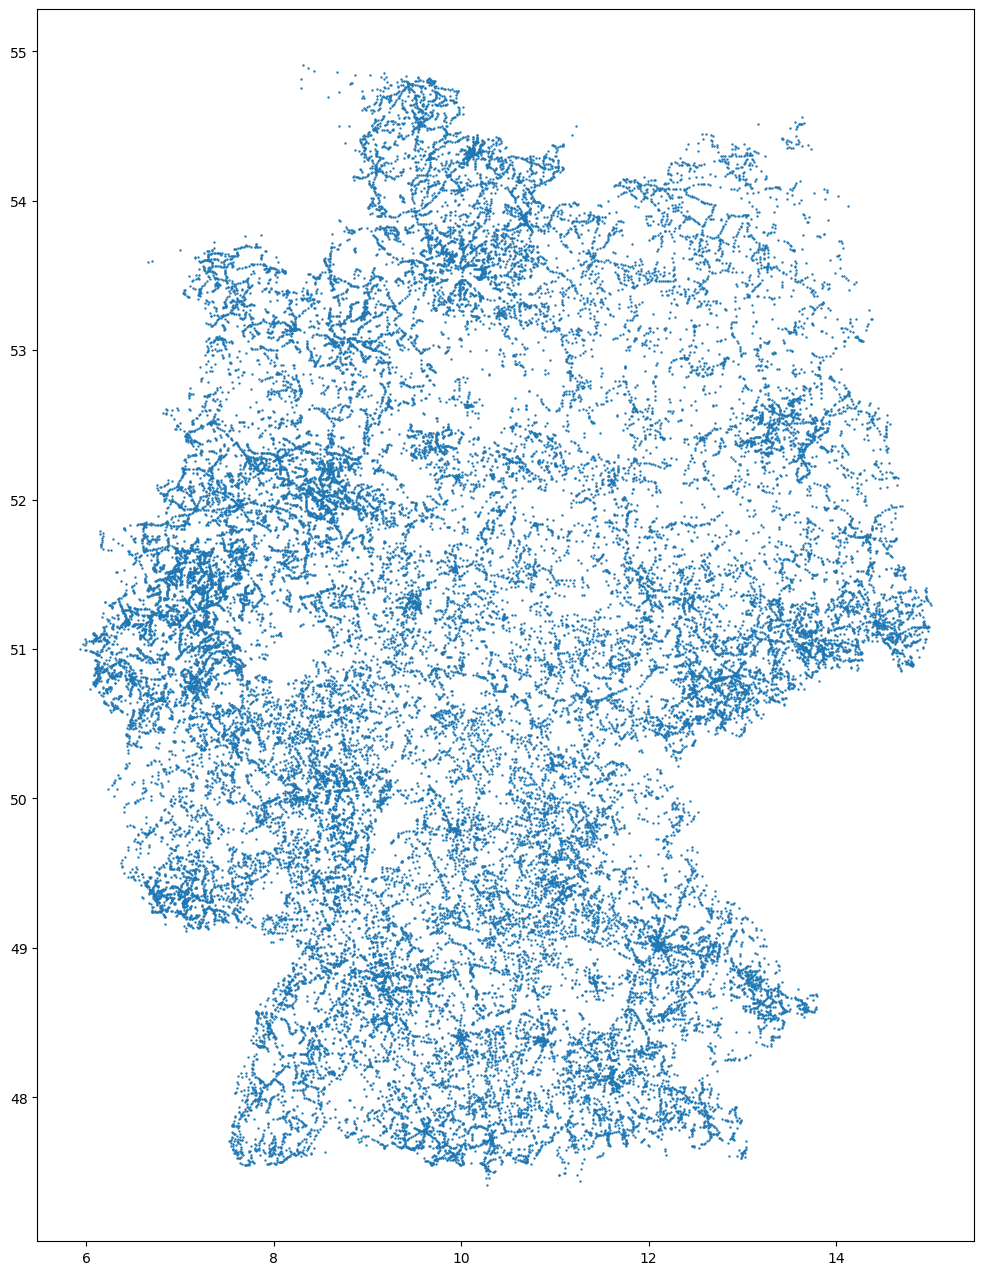

In [21]:
if manual: gpd.GeoDataFrame(agg_nodes).plot(markersize=.5, figsize=(16,16))

In [ ]:
#gpd.GeoDataFrame(agg_nodes[list(sm.nodes.columns)]).to_file('../agg_nodes.geojson', driver="GeoJSON")  

### Aggregate links

Aggregate those those trips with removed nodes.

In [22]:
# Function for aggregating links
geo_dict = agg_nodes['geometry'].to_dict()
def agg_trips(trip):
    # Drop links with missing nodes
    missing_nodes = list(set(trip[['a', 'b']].stack()).difference(set(agg_nodes.index)))
    trip_agg = trip.loc[~((trip['a'].isin(missing_nodes)) & trip['b'].isin(missing_nodes))
                       ].sort_values('link_sequence')
    if len(trip_agg.index) == 0:
        # Trip is fully irrelevant
        return
    
    if len(missing_nodes)==0 and len(trip.index)==len(trip_agg.index):
        # This trip is not affected
        return trip
    
    # Repair link succession
    ind = list(trip_agg.index)
    for i in range(len(ind) - 1):
        if trip_agg.loc[ind[i], 'b'] in missing_nodes:
            trip_agg.loc[ind[i + 1], 'a'] = trip_agg.loc[ind[i], 'a']
            trip_agg.drop(ind[i], inplace=True)
            i = i + 1
    
    ind = list(trip_agg.index)
    if len(trip_agg.index) > 0 and trip_agg.loc[ind[0], 'a'] in missing_nodes:
        # Drop unused first link
        trip_agg = trip_agg.iloc[1:]
    if len(trip_agg.index) > 0 and trip_agg.loc[ind[-1], 'b'] in missing_nodes:
        # Drop unused last link
        trip_agg = trip_agg.iloc[:-1]
    ind = list(trip_agg.index)
    if len(ind) == 0:
        return
    
    # Aggregate travel time
    for i in range(len(ind) - 1):
        try:
            assert trip_agg.loc[ind[i], 'b'] == trip_agg.loc[ind[i+1], 'a'], \
                'broken sequence in trip {}: stop {} has no successor link'.format(
                    trip_agg['trip_id'].unique()[0], trip_agg.loc[ind[i], 'b'])
        except AssertionError:
            # Drop this trip
            return
        if trip_agg.loc[ind[i + 1], 'link_sequence'] - trip_agg.loc[ind[i], 'link_sequence'] > 1:
            trip_agg.loc[ind[i], 'time'] = trip.loc[ind[i]:ind[i+1], 'time'].sum() - \
                trip_agg.loc[ind[i+1], 'time'] # pandas slicing includes both boundaries
    
    # Reindex the sequence numbers
    trip_agg['link_sequence'] = [i for i in range(1, len(trip_agg.index)+1)]
    
    # Build geometries
    try:
        trip_agg['geometry'] = [geometry.LineString([geo_dict[a], geo_dict[b]])
                                for a,b in zip(trip_agg['a'], trip_agg['b'])]
    except KeyError:
        return
    
    return trip_agg

In [23]:
# Faster variant for using multiple cores
#import multiprocessing as mp
#with mp.Pool(processes=4) as p:
#    agg_links = pd.concat(p.map(
#        agg_trips, [g for _, g in agg_links.groupby('trip_id')]))
agg_links = agg_links.groupby('trip_id').apply(agg_trips).reset_index(level=0, drop=True)
len(agg_links)

146349

In [24]:
# Links with stops that should be dropped
errors = agg_links.loc[~(agg_links['a'].isin(list(agg_nodes.index))) |
    ~(agg_links['b'].isin(list(agg_nodes.index)))]
print(len(errors))
print(errors['link_sequence'].unique())
print(errors['route_type'].unique())

0
[]
[]


In [25]:
# Drop these erronous trips
agg_links = agg_links.loc[~agg_links['trip_id'].isin(list(agg_links.loc[errors.index, 'trip_id']))]
agg_links.shape

(146349, 10)

In [26]:
# Drop trips with different IDs but same stop sequences
s = agg_links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
agg_links = agg_links.loc[agg_links['trip_id'].isin(s.index)]
agg_links.shape

(146175, 10)

## Build footpaths

In addition to those generated above, build footpaths between agg_nodes, between long-distance nodes (because they overlay each other), and between centroids.

In [27]:
# Build footbaths between aggregated short-distance nodes
for o in agg_nodes['route_type'].unique():
    for d in agg_nodes['route_type'].unique():
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                agg_nodes.loc[agg_nodes['route_type']==o],
                agg_nodes.loc[agg_nodes['route_type']==d],
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_bicycle'],
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=params['access-egress_links']['n_short-pt_short-pt'],
                coordinates_unit=sm.coordinates_unit)
            ntlegs = ntlegs.loc[ntlegs['distance']<=
                                params['access-egress_links']['walk_max_dist']
                                + params['clustering']['radius_'+d]/2]
            sm.footpaths = pd.concat([sm.footpaths, ntlegs])
len(sm.footpaths)

13650

In [28]:
# Between long-distance nodes
for o in sm.nodes['route_type'].unique():
    for d in sm.nodes['route_type'].unique():
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.nodes.loc[sm.nodes['route_type']==o],
                sm.nodes.loc[sm.nodes['route_type']==d],
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_bicycle'],
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=params['access-egress_links']['n_long-pt_long-pt'],
                coordinates_unit=sm.coordinates_unit)
            if o == 'air':
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_air_max_dist']
                                    + params['clustering']['radius_'+d]/2]
            else:
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_max_dist']
                                    + params['clustering']['radius_'+o]/2
                                    + params['clustering']['radius_'+d]/2]
            sm.footpaths = pd.concat([sm.footpaths, ntlegs])
sm.footpaths.drop_duplicates(['a', 'b'], inplace=True)
len(sm.footpaths)

16474

In [29]:
# Reindex
sm.footpaths.drop_duplicates(['a', 'b'], inplace=True)
sm.footpaths.reset_index(drop=True, inplace=True)
sm.footpaths.index = 'foot_' + pd.Series(sm.footpaths.index).astype(str)
sm.footpaths.sample()

,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time
foot_3133,rs_59620040_3,b_59620040_57,0,116.890001,"LINESTRING (7.774233 51.45894, 7.7757855 51.45...",access,0.540578,5,15,5.0,84.1608


In [30]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank']
sm.footpaths.drop(cols, axis=1, inplace=True, errors='ignore')
sm.footpaths.shape

(16474, 7)

## Connect to centroids

Build access/egress links to the most important stops.

In [31]:
# Compute controids
sm.centroids = gpd.GeoDataFrame(sm.zones[['FID', 'NUTS_ID']],
                                geometry=gpd.points_from_xy(sm.zones['lat'], sm.zones['lon'], crs=sm.epsg),
                                crs=sm.epsg)
sm.zone_to_transit = pd.DataFrame()

In [32]:
# Count the connectivity of start nodes in links table
n_links_dict = pd.concat([sm.links[['a', 'b']], agg_links[['a', 'b']]]).stack().value_counts().to_dict()
agg_links['n_links'] = agg_links['a'].map(n_links_dict)

In [33]:
# Compute PT access and egress links for short-distance trips
# Connects only nodes within the corresponding zone
for z in tqdm(sm.centroids['FID'].unique()):
    for t in agg_nodes['route_type'].unique():
        nodes = agg_nodes.loc[(agg_nodes['route_type']==t) & (agg_nodes['FID']==z)]
        if len(nodes) > 0:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.centroids.loc[sm.centroids['FID']==z],
                nodes,
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_car'], # Take the car for longer trips
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=min([len(nodes), 20]),
                coordinates_unit=sm.coordinates_unit)
            # Cut off long links
            ntlegs = ntlegs.loc[ntlegs['distance']<=
                                params['access-egress_links']['pt_max_dist']]
            ntlegs['route_type'] = t
            # Merge
            sm.zone_to_transit = pd.concat([sm.zone_to_transit, ntlegs])
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

100%|██████████████████████████████████████████████████████████████████████████████| 4602/4602 [05:17<00:00, 14.49it/s]


74300

In [34]:
# Compute PT access and egress links for short-distance trips
# Connect zones without own nodes to one node in the corresponding NUTS zone
missing_zones = list(set(sm.centroids.index)
                     - set(sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access', 'a']))
for z in tqdm(missing_zones):
    for t in agg_nodes['route_type'].unique():
        nuts_zones = list(sm.zones.loc[sm.zones['NUTS_ID']==sm.zones.loc[z, 'NUTS_ID'], 'FID'])
        nodes = agg_nodes.loc[(agg_nodes['route_type']==t) & (agg_nodes['FID'].isin(nuts_zones))]
        if len(nodes) > 0:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.centroids.loc[sm.centroids['FID']==z],
                nodes,
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_car'], # Take the car for longer trips
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=1,
                coordinates_unit=sm.coordinates_unit)
            # Cut off long links
            ntlegs = ntlegs.loc[ntlegs['distance']<=
                                params['access-egress_links']['pt_max_dist']]
            ntlegs['route_type'] = t
            # Merge
            sm.zone_to_transit = pd.concat([sm.zone_to_transit, ntlegs])
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [00:15<00:00, 21.00it/s]


74962

In [35]:
# Compute PT access and egress links for long-distance trips
# only within the corresponding zone
missing_zones = []
for z in tqdm(sm.centroids.index):
    for t in sm.links['route_type'].unique():
        nodes = sm.nodes.loc[(sm.nodes['route_type']==t) & (sm.nodes['FID']==z)]
        if len(nodes) > 0:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.centroids.loc[[z]],
                nodes,
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_car'], # Take the car for longer trips
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=len(nodes),
                coordinates_unit=sm.coordinates_unit)
            # Cut off long links
            ntlegs = ntlegs.loc[ntlegs['distance']<=
                                params['access-egress_links']['pt_max_dist']]
            ntlegs['route_type'] = t
            # Merge
            sm.zone_to_transit = pd.concat([sm.zone_to_transit, ntlegs])
        else:
            missing_zones.append(z)
# Connect zones without own nodes to one node in the corresponding NUTS zone
for z in tqdm(set(missing_zones)):
    for t in agg_nodes['route_type'].unique():
        nuts_zones = list(sm.zones.loc[sm.zones['NUTS_ID']==sm.zones.loc[z, 'NUTS_ID'], 'FID'])
        nodes = sm.nodes.loc[(sm.nodes['route_type']==t) & (sm.nodes['FID'].isin(nuts_zones))]
        if len(nodes) > 0:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.centroids.loc[sm.centroids['FID']==z],
                nodes,
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_car'], # Take the car for longer trips
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=1,
                coordinates_unit=sm.coordinates_unit)
            # Cut off long links
            ntlegs = ntlegs.loc[ntlegs['distance']<=
                                params['access-egress_links']['pt_max_dist']]
            ntlegs['route_type'] = t
            # Merge
            sm.zone_to_transit = pd.concat([sm.zone_to_transit, ntlegs])
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

100%|██████████████████████████████████████████████████████████████████████████████| 4592/4592 [00:47<00:00, 97.66it/s]


89508

In [36]:
# Prepare connectors for filtering
sm.zone_to_transit['distance'] = sm.zone_to_transit['geometry'].apply(lambda l: l.length)
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access']
access['n_links'] = access['b'].map(n_links_dict)
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress']
egress['n_links'] = egress['a'].map(n_links_dict)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_11188\375334251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access['n_links'] = access['b'].map(n_links_dict)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_11188\375334251.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egress['n_links'] = egress['a'].map(n_links_dict)


In [37]:
# Filter: search for highest connectivity and shortest links per route_type
access = pd.concat([
    access.sort_values('n_links', ascending=False).groupby(['a', 'route_type']).nth(
        list(range(params['access-egress_links']['keep_n_highest_connectivity']))
    ).reset_index(),
    access.sort_values('distance').groupby(['a', 'route_type']).nth(
        list(range(params['access-egress_links']['keep_n_closest']))
    ).reset_index()]
).drop_duplicates(['a', 'b'])
egress = pd.concat([
    egress.sort_values('n_links', ascending=False).groupby(['b', 'route_type']).nth(
        list(range(params['access-egress_links']['keep_n_highest_connectivity']))
    ).reset_index(),
    egress.sort_values('distance').groupby(['b', 'route_type']).nth(
        list(range(params['access-egress_links']['keep_n_closest']))
    ).reset_index()]
).drop_duplicates(['a', 'b'])

In [38]:
sm.zone_to_transit = pd.concat([access, egress]).reset_index(drop=True)
sm.zone_to_transit.drop('n_links', axis=1, inplace=True)
sm.zone_to_transit.shape

(45686, 13)

In [39]:
# Every zone should have an access and an egress link to PT
try:
    assert sm.zones['FID'].isin(list(sm.zone_to_transit['a'])).all()
except AssertionError:
    print(sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_transit['a']))].index)
try:
    assert sm.zones['FID'].isin(list(sm.zone_to_transit['b'])).all()
except AssertionError:
    print(sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_transit['b']))].index)

### Parametrise access and egress  links

Add distance, speed and time. Average distances by zone and mode should have been calculated based on census data before.

In [40]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank']
sm.zone_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [41]:
# Load distances to PT stops from census data
clusters = pd.read_csv(input_path + 'spatial_census_refined.csv')
#clusters.set_index('Unnamed: 0', inplace=True)
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'
# Create a zone - distance - type dict
# Take the mean weighted distance
zone = 'FID' if 'FID' in clusters.columns else 'NUTS_ID'
zone_type_dist = clusters.groupby([zone, 'route_type']).agg(
    {mean_dist_col: 'mean'}).to_dict()[mean_dist_col]

In [42]:
# Adjust distances
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access']
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress']
access['distance'] = [zone_type_dist[(z, t)] if (z, t) in zone_type_dist.keys() else np.nan
                      for z,t in zip(access['a'], access['route_type'])]
egress['distance'] = [zone_type_dist[(z, t)] if (z, t) in zone_type_dist.keys() else np.nan
                      for z,t in zip(egress['b'], egress['route_type'])]
sm.zone_to_transit = pd.concat([access, egress])

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_11188\395418763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access['distance'] = [zone_type_dist[(z, t)] if (z, t) in zone_type_dist.keys() else np.nan
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_11188\395418763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  egress['distance'] = [zone_type_dist[(z, t)] if (z, t) in zone_type_dist.keys() else np.nan


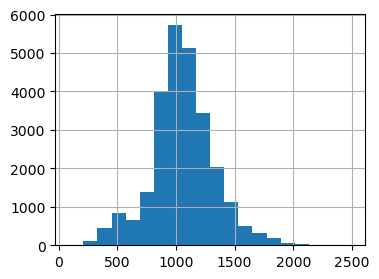

In [43]:
# Distance distribution among access/egress links
if manual: sm.zone_to_transit['distance'].hist(bins=20, figsize=(4,3))

In [44]:
len(sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna()])

19686

In [46]:
# Connectors to/from long-distance nodes in the same zone
# Assign average distance of the corresponding urbanisation degree
node_dict = sm.nodes['FID'].to_dict()
urban_dict = sm.zones['urbanisation'].to_dict()
clusters['u'] = clusters[zone].map(urban_dict)
mean_distances = clusters.groupby(['u', 'route_type'])[mean_dist_col].mean().to_dict()
mask = (sm.zone_to_transit['distance'].isna()) \
    & (((sm.zone_to_transit['direction']=='access')
        & (sm.zone_to_transit['a']==sm.zone_to_transit['b'].map(node_dict)))
       | ((sm.zone_to_transit['direction']=='eggress')
          & (sm.zone_to_transit['b']==sm.zone_to_transit['a'].map(node_dict))))
sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access', 'u'] = \
    sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access', 'a'].map(urban_dict)
sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress', 'u'] = \
    sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress', 'b'].map(urban_dict)
sm.zone_to_transit.loc[mask, 'distance'] = [mean_distances[(u, t)] for u,t in zip(
    sm.zone_to_transit.loc[mask, 'u'], sm.zone_to_transit.loc[mask, 'route_type'])]
len(sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna()])

0

In [47]:
# Connectors to/from long-distance nodes in other zones
# Drop NaN, because they cause that people don't take short-distance PT,
# but walk over to the next airport and walk to the neighboring centroid
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['distance'].notna()]
sm.zone_to_transit.shape

(45686, 10)

In [48]:
# Correct speeds based on access/egress modes
speeds = {'walk': params['pt_access']['speed_walk'],
          'bicycle': params['pt_access']['speed_bicycle'],
          'car': params['pt_access']['speed_car']} # km/h
sm.zone_to_transit['speed'] = [sum([speed * params['pt_access']['urban'+str(int(u))+'_'+mode+'_share'
                                                               ] for mode, speed in speeds.items()])
                               for u in sm.zone_to_transit['u']]

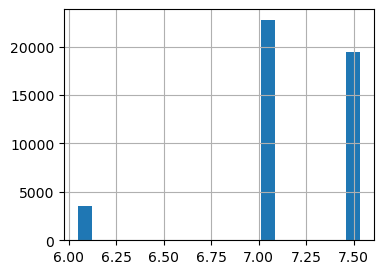

In [49]:
# Speed distribution among access/egress links
if manual: sm.zone_to_transit['speed'].hist(bins=20, figsize=(4,3))

In [50]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / \
    sm.zone_to_transit['speed'] * 3.6 # in s

In [51]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<2*3600]
len(sm.zone_to_transit)

45686

In [52]:
# Every zone should have an access and an egress link to PT
try:
    assert sm.zones['FID'].isin(list(sm.zone_to_transit['a'])).all()
except AssertionError:
    print(sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_transit['a']))].index)
try:
    assert sm.zones['FID'].isin(list(sm.zone_to_transit['b'])).all()
except AssertionError:
    print(sm.zones.loc[~sm.zones['FID'].isin(list(sm.zone_to_transit['b']))].index)

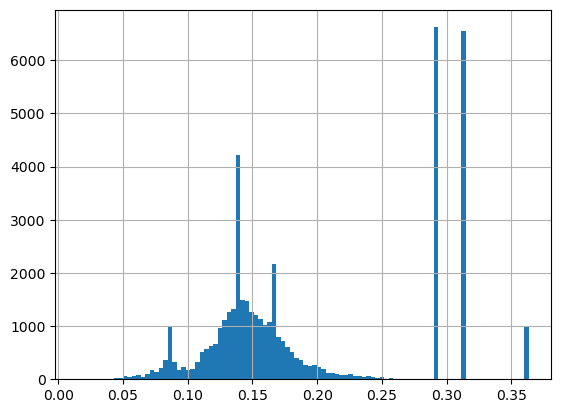

In [53]:
# Time distribution of access/egress links in hours
if manual: (sm.zone_to_transit['time']/3600).hist(bins=100)

In [54]:
sm.zone_to_transit.sample()

,index,a,b,distance,geometry,direction,speed,time,route_type,u
14448,77758,57660056,rs_57660056_0,1125.227419,"LINESTRING (8.66135 51.952315, 8.714725 51.97738)",access,7.013335,577.588082,rail_short,2.0


## Merge aggregated links and nodes with the model

In [55]:
# Re-add links to model
sm.links = pd.concat([sm.links, agg_links[list(sm.links.columns)]])
sm.links.shape

(212945, 10)

In [56]:
# Re-add nodes to the model
sm.nodes = pd.concat([sm.nodes, agg_nodes[list(sm.nodes.columns)]])
sm.nodes.shape

(51212, 3)

In [57]:
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Number of orphan nodes: {}'.format(
        len(sm.orphan_nodes)))
    print('Number of missing nodes: {}'.format(
        len(sm.missing_nodes)))

Number of orphan nodes: 1082
Number of missing nodes: 0


In [58]:
assert len(sm.missing_nodes) == 0
if len(sm.orphan_nodes) > 0:
    sm.nodes = sm.nodes.drop(sm.orphan_nodes)
    sm.nodes.shape

In [59]:
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

,route_type,a,b,route_type_disagg,geometry,link_sequence,route_id,time,trip_id,headway
index,,,,,,,,,,
rs_2661,rail_short,rs_71375009_2,rs_71375009_4,rail_short,"LINESTRING (7.413508 50.227676, 7.443512 50.23...",7,rs_119,120,rs_119_16,43200


In [60]:
# Drop footpaths to nowhere
sm.footpaths = sm.footpaths.loc[(sm.footpaths['a'].isin(sm.nodes.index))
                                & (sm.footpaths['b'].isin(sm.nodes.index))]
len(sm.footpaths)

11834

## Save model
And reduce the file size

In [61]:
# Cast columns to int with 16 bits
cols = ['time', 'link_sequence', 'headway']
sm.links['headway'].clip(lower=0, upper=2**16-1, inplace=True)
sm.links[cols] = sm.links[cols].astype('UInt16')

In [62]:
# Also nodes zone ID
if np.issubdtype(sm.nodes['FID'].dtype, np.number):
    sm.nodes['FID'] = sm.nodes['FID'].astype(int)

In [63]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['a', 'b', 'link_sequence', 'route_id', 'time', 'trip_id', 'headway', 'route_type_disagg']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [64]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')
sm.to_json(model_path + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]


In [65]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_11188\3077141698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auxiliary['index'] = auxiliary.index


In [66]:
# Save reduced access/egress links
sm.to_json(model_path + 'de_pt_access_egress', only_attributes=[
    'centroids', 'footpaths', 'zone_to_transit'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]
